# Bayesian Machine Learning - MVA Master - Eugène Berta

This notebook allows to reproduce the experiments and figures described in my project report.

In [1]:
import torch
from torch import optim
import matplotlib.pyplot as plt
from torch.distributions import kl_divergence
from utils import Boost_FKL, MC_FKL, MC_RKL, plot_distribs
from utils import GaussianParticle, GaussianMixture

## 1. Fitting simple Gaussians

In a first part, we validate our implementation by fitting a simple Gaussian model on a Gaussian target.

In [2]:
# Non trainable Gaussian particle, target of the model.
target = GaussianParticle(
    loc=torch.tensor([2.,2.]),
    scale_tril=0.5*torch.eye(2),
    trainable=False
)

### 1.1 RKL

As we use simple Gaussians, we can use PyTorch kl_divergence function that computes the KL using the closed form expression of KL between normal distributions:

step:0, loss:4.296090126037598
step:500, loss:0.0
step:1000, loss:0.0
step:1500, loss:0.0


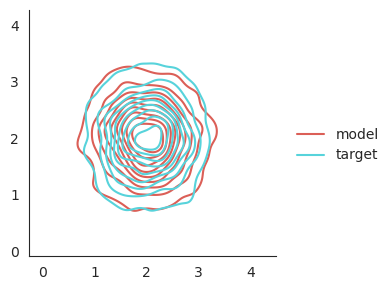

In [3]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=0.01)

for step in range(2000):
    loss = kl_divergence(p=target.mvn, q=model.mvn)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%500==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

plot_distribs({'model':model, 'target':target})

The result is very convincing, however, in the general case, we don't have a closed form expression of the KL between q and p. Our implementation of reverse KL, the function MC_RKL uses a Monte-Carlo estimation of the KL by sampling in q. It introduces a lot of variance in the result:

step:0, loss:32.76766586303711
step:500, loss:nan
step:1000, loss:nan
step:1500, loss:nan


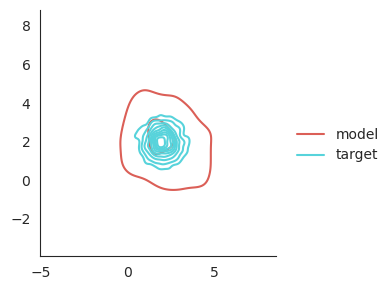

In [4]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=0.01)

for step in range(2000):
    loss = MC_RKL(p=target, q=model)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%500==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

plot_distribs({'model':model, 'target':target})

### 1.2 FKL

To compute the Forward Kullback Leibler divergence between q and p we have two options:
- either we use the function MC_FKL that works similarly to MC_RKL and performs a Self-Normalized Importance Sampling estimate of FKL by sampling in q and using the importance sampling trick to simulate a sampling over p.
- either we use the function Boost_FKL that corresponds to the method introduced in the paper to compute FKL in the context of a boosting procedure, it requires initialization.

We start with MC_FKL:

step:0, loss:3.3371753692626953
step:500, loss:1.7643826007843018
step:1000, loss:1.055139422416687
step:1500, loss:0.5525344610214233


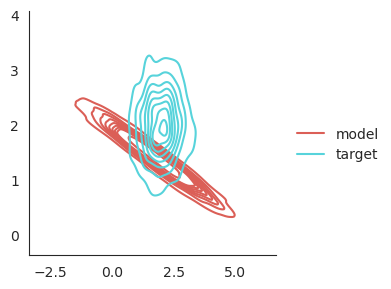

In [5]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=0.001)

for step in range(2000):
    loss = MC_FKL(p=target, q=model)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%500==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

plot_distribs({'model':model, 'target':target})

Our function does not always work in this case, the optimization seems really noisy. As it is explained in the paper, the SNIS estimate has a large variance as we are sampling and optimizing on the same distribution. To mitigate this effect, we can initialize a Gaussian Mixture Model with a diffuse distribution and sample from that distribution during the optimization, as detailed in the paper.

We implement this method with our Boost_FKL loss function:

step:0, loss:3.5111756324768066
step:500, loss:0.056899942457675934
step:1000, loss:0.0185624361038208
step:1500, loss:0.009116938337683678


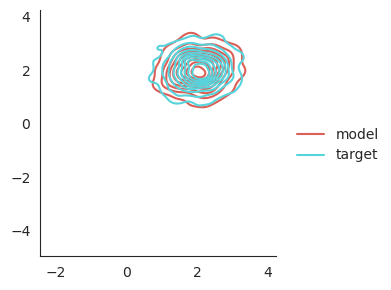

In [6]:
# Initializing a Gaussian mixture model with a non-trainable diffuse gaussian distributions:
init= GaussianParticle(
    loc=torch.zeros(2),
    scale_tril=2*torch.eye(2),
    trainable=False
)
model = GaussianMixture(init)

# Trainable Gaussian particle with random initialization.
particle = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# Optimization procedure:
opt = optim.Adam(particle.parameters(), lr=0.01)

for step in range(2000):
    loss = Boost_FKL(
        f=particle,
        q=model,
        p=target
    )
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%500==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

# Adding the new particle to the model:
model.add_particle(particle)

plot_distribs({'model':model, 'target':target})

The result of the paper seem validated, this method works much better.

## 2. Fitting a multimodal target

In this second part, we try to fit a multimodal target to illustrate the "mass covering" effect of the FKL described in the paper.

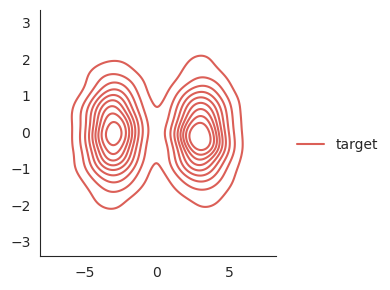

In [7]:
# Non trainable gaussian mixture, target of the model:
particle1 = GaussianParticle(
    loc=torch.tensor([3,0], dtype=torch.float),
    scale_tril=0.8*torch.eye(2),
    trainable=False
)
particle2 = GaussianParticle(
    loc=torch.tensor([-3,0], dtype=torch.float),
    scale_tril=0.8*torch.eye(2),
    trainable=False
)
target = GaussianMixture(particle1)
target.add_particle(particle2)

plot_distribs({'target':target}, nsamples=2000)

### 2.1 RKL

In [8]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=0.01)

for step in range(2000):
    loss = MC_RKL(p=target, q=model)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%500==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

plot_distribs({'target':target, 'model':model})

step:0, loss:5.379206657409668


ValueError: Expected value argument (Tensor of shape (1000, 2)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution MultivariateNormal(loc: torch.Size([2]), scale_tril: torch.Size([2, 2])), but found invalid values:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], grad_fn=<AddBackward0>)

As described in the paper, we observe a "mode seeking" behavior when the optimization runs, even with the high variance of MC_RKL.

### 2.2 MC_FKL

For a simple case like this, we can hope that MC_FKL can run and give us interpretable results on the behavior of FKL. For real life applications, the variance is too high and only the boosting technique can be applied.

step:0, loss:2.0829813480377197
step:500, loss:1.8684831857681274
step:1000, loss:1.3273887634277344
step:1500, loss:1.0984489917755127


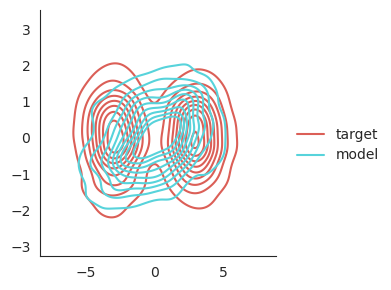

In [ ]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=0.001)

for step in range(2000):
    loss = MC_FKL(p=target, q=model)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%500==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

plot_distribs({'target':target, 'model':model})

When the optimization runs, we observe this type of "mass covering" behavior as described in the paper. This is the advantage of FKL that the paper tries to take advantage of. However, even in this very simple case, the optimisation is very noisy and the results unstable, it is hard to conclude in a proper manner.

### 2.2 FKL from diffuse initialization

step:0, loss:1.4499105215072632
step:500, loss:0.9414904713630676
step:1000, loss:1.077894687652588
step:1500, loss:0.8965429663658142
step:2000, loss:1.0417094230651855
step:2500, loss:0.901042103767395


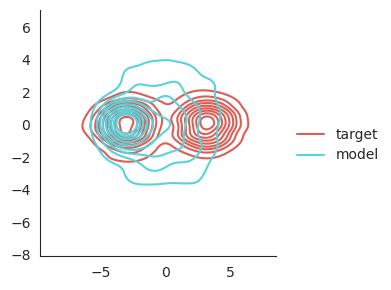

In [ ]:
# Initializing a Gaussian mixture model with a non-trainable diffuse gaussian distributions:
init= GaussianParticle(
    loc=torch.zeros(2),
    scale_tril=2*torch.eye(2),
    trainable=False
)
model = GaussianMixture(init)

# Trainable Gaussian particle with random initialization.
particle = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# Optimization procedure:
opt = optim.Adam(particle.parameters(), lr=0.005)

for step in range(3000):
    loss = Boost_FKL(
        q=model,
        p=target,
        f=particle
    )
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%500==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

# Adding the new particle to the model:
model.add_particle(particle)

plot_distribs({'target':target, 'model':model})

In this case, the optimization always runs, the algorithm is much more stable. The efforts to mitigate the variance of the SNIS estimate are successfull.

However, the model oscillates between two different results:
- The mass covering behavior that we are expecting from FKL.
- The same mode seeking behavior that is characteristic of RKL.

The boosting procedure reduces drastically the variance of the FKL estimate, and thus allows for the computation of the Loss. However we argue it introduces two perverse effects in the algorithm.

First, the diffuse initialization that we use can alter the ideal behavior of FKL. Indeed, the diffuse initialization puts a minimum amount of mass everywhere and thus it satisfies the mass covering constraint in the FKL objective. This can create local minimas in the loss landscape where the new particle covers only one mode of the distribution. The model relies on it's diffuse initialization to satisfy the hard constraint that it must cover all of the target distribution but it is highly unbalanced towards one mode. This would not be possible if we could fit our model using the true FKL.

This issue one could argue, is mitigated by the proposal of the authors to initialize the boosting with a first particle fitted with RKL. This particle would cover only one mode of the target distribution and the mass covering constraint of the FKL would be enforced in the second optimization. First, we recall that this does nos correspond to the original idea of the paper, which is precisely not to fit one distribution on each mode of the target. Then, we argue that initializing with RKL drastically reduces the expressivity of the model, making the choice between diffuse and RKL initialization a problem with no satisfying answer. Indeed, to compute the SNIS estimate for the current step, the boosting procedure uses samples from the previous state of the model. With RKL initialization, the model is initialzed with a distribution covering a single mode. The samples from such a distribution will catastrophically fail to carry useful information about how to cover other modes of the multimodal distribution. We illustrate this effect with a more complex target in the next section.

## 3. Fitting a boosting model on a complex multi-modal distribution.

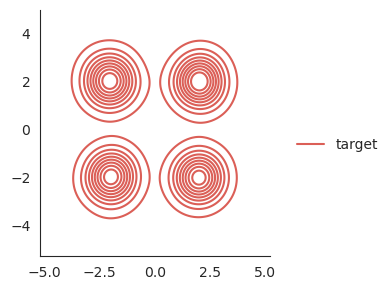

In [18]:
# Non trainable gaussian mixture:
particle1 = GaussianParticle(
    loc=torch.tensor([2,2], dtype=torch.float),
    scale_tril=0.4*torch.eye(2),
    trainable=False
)
particle2 = GaussianParticle(
    loc=torch.tensor([-2,2], dtype=torch.float),
    scale_tril=0.4*torch.eye(2),
    trainable=False
)
particle3 = GaussianParticle(
    loc=torch.tensor([2,-2], dtype=torch.float),
    scale_tril=0.4*torch.eye(2),
    trainable=False
)
particle4 = GaussianParticle(
    loc=torch.tensor([-2,-2], dtype=torch.float),
    scale_tril=0.4*torch.eye(2),
    trainable=False
)
multimodal_target = GaussianMixture(particle1)
multimodal_target.add_particle(particle2)
multimodal_target.add_particle(particle3)
multimodal_target.add_particle(particle4)

multimodal_target.weights = torch.ones(4)/4

plot_distribs({'target':multimodal_target}, nsamples=2000)

### 3.1 Diffuse initialization

### step=1, fitting a new particle ###
step:0, loss:2.4801502227783203
step:500, loss:1.9977465867996216
step:1000, loss:1.9002017974853516
step:1500, loss:nan
step:2000, loss:nan
step:2500, loss:1.7933610677719116
### step=2, fitting a new particle ###
step:0, loss:2.111715078353882
step:500, loss:1.7006027698516846
step:1000, loss:1.5931384563446045
step:1500, loss:nan
step:2000, loss:nan
step:2500, loss:1.4586386680603027
### step=3, fitting a new particle ###
step:0, loss:1.7759568691253662
step:500, loss:1.4446618556976318
step:1000, loss:1.482656478881836
step:1500, loss:nan
step:2000, loss:1.4038599729537964
step:2500, loss:1.2746665477752686


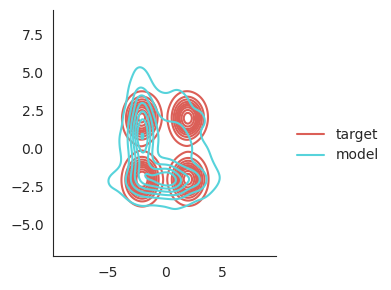

In [19]:
# Diffuse initialization:
init = GaussianParticle(
    loc=torch.tensor([0.,0.]),
    scale_tril=2*torch.eye(2),
    trainable=False
)

# FKL BOOSTING:
model = GaussianMixture(init)

K = 3
for i in range(K):
    print(f'### step={i+1}, fitting a new particle ###')
    new_particle = GaussianParticle(
        loc=torch.randn(2),
        scale_tril=torch.eye(2),
        trainable=True
    )

    opt = optim.Adam(new_particle.parameters(), lr=0.001)

    for step in range(3000):
        loss = Boost_FKL(
            q=model,
            p=multimodal_target,
            f=new_particle
        )
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        # logging:
        if step%500==0:
            print(f'step:{step}, loss:{loss.detach().numpy()}')
    
    for param in new_particle.parameters():
        param.requires_grad = False

    model.add_particle(new_particle)

plot_distribs({'target':multimodal_target, 'model':model}, nsamples=2000)

In [20]:
print(f'mixture weights: {model.weights}')
for i in range(len(model.particles)):
    print(f'particle {i}, mean = {model.particles[i].loc.detach().numpy()}')

mixture weights: tensor([0.3542, 0.1165, 0.2733, 0.2559])
particle 0, mean = [0. 0.]
particle 1, mean = [0.36423188 0.5203905 ]
particle 2, mean = [-0.05177202 -2.0374074 ]
particle 3, mean = [-2.0314915  1.0553598]


The mass covering constraint is satisfied even if the mass is not well spread between the distributions.

### 3.2 RKL initialization

### step=1, fitting a new particle ###
step:0, loss:-0.6172112226486206
step:500, loss:-0.8526356816291809
step:1000, loss:-1.0475096702575684
step:1500, loss:-1.152442455291748
step:2000, loss:-1.3050320148468018
step:2500, loss:-1.3507354259490967
### step=2, fitting a new particle ###
step:0, loss:-0.6638228893280029
step:500, loss:-0.9315997362136841
step:1000, loss:-1.1061670780181885
step:1500, loss:-1.189866065979004
step:2000, loss:-1.2800192832946777
step:2500, loss:-1.364343523979187
### step=3, fitting a new particle ###
step:0, loss:-0.7212402820587158
step:500, loss:-0.9872663021087646
step:1000, loss:-1.1594189405441284
step:1500, loss:-1.3193941116333008
step:2000, loss:-1.3769207000732422
step:2500, loss:-1.378942847251892


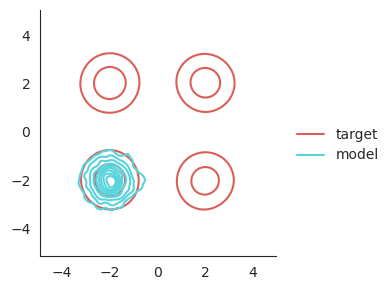

In [21]:
# As our RKL is not very reliable, we simulate a RKL initialization that covers only one mode:
init = GaussianParticle(
    loc=torch.tensor([-2,-2.]),
    scale_tril=0.5*torch.eye(2),
    trainable=False
)

# FKL BOOSTING:
model = GaussianMixture(init)

K = 3
for i in range(K):
    print(f'### step={i+1}, fitting a new particle ###')
    new_particle = GaussianParticle(
        loc=torch.randn(2),
        scale_tril=torch.eye(2),
        trainable=True
    )

    opt = optim.Adam(new_particle.parameters(), lr=0.001)

    for step in range(3000):
        loss = Boost_FKL(
            q=model,
            p=multimodal_target,
            f=new_particle
        )
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        # logging:
        if step%500==0:
            print(f'step:{step}, loss:{loss.detach().numpy()}')
    
    for param in new_particle.parameters():
        param.requires_grad = False

    model.add_particle(new_particle)

plot_distribs({'target':multimodal_target, 'model':model}, nsamples=2000)

In [22]:
print(f'mixture weights: {model.weights}')
for i in range(len(model.particles)):
    print(f'particle {i}, mean = {model.particles[i].loc.detach().numpy()}')

mixture weights: tensor([0.4420, 0.1385, 0.1461, 0.2733])
particle 0, mean = [-2. -2.]
particle 1, mean = [-1.9996817 -2.001174 ]
particle 2, mean = [-2.0001962 -2.0025434]
particle 3, mean = [-1.999976 -2.007299]


The model struggles to escape the initialization mode and the mass covering is limited, as illustrated by the negative values of the loss.